Importing the Libraries

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [78]:
gold_data = pd.read_csv('/content/gld_price_data.csv')

# GAN parameters
latent_dim_gan = 100
output_shape_gan = gold_data.shape[1] - 1  # Adjust this based on the number of features
num_synthetic_samples_gan = 4000

# Define a simple GAN generator model
def build_generator(latent_dim, output_shape):
    model = Sequential()  # Use Sequential directly from tensorflow.keras.models
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))  # Adjust activation based on your data
    return model

# Function to train the GAN generator
def train_gan_generator(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    fake_samples = generator.predict(noise)
    return fake_samples

# Build and compile the GAN generator model
generator = build_generator(latent_dim_gan, output_shape_gan)
generator.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss based on your data

# Train the GAN generator
synthetic_data_gan = train_gan_generator(generator, latent_dim_gan, num_synthetic_samples_gan)

# Combine original and synthetic data
combined_data = pd.concat([gold_data.drop(['GLD'], axis=1), pd.DataFrame(synthetic_data_gan, columns=gold_data.columns[1:])], ignore_index=True)
combined_labels = pd.concat([gold_data['GLD'], pd.Series(np.zeros(num_synthetic_samples_gan))], ignore_index=True)


# Splitting into Training data and Test Data (use the combined data)
X_train_combined, X_test_combined, Y_train_combined, Y_test_combined = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=2
)


125/125 [==============================] - 1s 3ms/step


In [110]:
# Combine original and synthetic data
combined_data = pd.concat([gold_data.drop('GLD', axis=1), pd.DataFrame(synthetic_data_gan, columns=gold_data.columns[1:])], ignore_index=True)
combined_labels = pd.concat([gold_data['GLD'], pd.Series(np.zeros(num_synthetic_samples_gan))], ignore_index=True)

# Print the number of samples before and after combining
print("Number of samples before combining:", len(gold_data))
print("Number of synthetic samples generated by GAN:", num_synthetic_samples_gan)
print("Number of samples after combining:", len(combined_data))


Number of samples before combining: 2290
Number of synthetic samples generated by GAN: 4000
Number of samples after combining: 6290


Data Collection and Processing

In [82]:
# print first 5 rows in the dataframe
combined_data.head()

,Date,SPX,USO,SLV,EUR/USD,GLD
0,1/2/2008,1447.160034,78.470001,15.180,1.471692,NaN
1,1/3/2008,1447.160034,78.370003,15.285,1.474491,NaN
2,1/4/2008,1411.630005,77.309998,15.167,1.475492,NaN
3,1/7/2008,1416.180054,75.500000,15.053,1.468299,NaN
4,1/8/2008,1390.189941,76.059998,15.590,1.557099,NaN


In [83]:
# print last 5 rows of the dataframe
combined_data.tail()

,Date,SPX,USO,SLV,EUR/USD,GLD
6285,NaN,-0.313806,-0.247641,-0.165609,0.569263,0.342945
6286,NaN,-0.952160,-0.308130,0.033734,0.543201,0.698368
6287,NaN,-0.883336,0.350766,0.403492,0.388726,-0.321550
6288,NaN,-0.185966,0.027176,0.057446,0.031206,-0.565500
6289,NaN,0.269370,0.197418,0.067187,0.066633,-0.581690


In [84]:
# number of rows and columns
combined_data.shape

(6290, 6)

In [108]:
# getting some basic informations about the data
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      6290 non-null   float64
 2   USO      6290 non-null   float64
 3   SLV      6290 non-null   float64
 4   EUR/USD  6290 non-null   float64
 5   GLD      4000 non-null   float32
dtypes: float32(1), float64(4), object(1)
memory usage: 270.4+ KB


In [109]:
# checking the number of missing values
combined_data.isnull().sum()

Date       4000
SPX           0
USO           0
SLV           0
EUR/USD       0
GLD        2290
dtype: int64

# New Section

In [47]:
# getting the statistical measures of the data
gold_data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


Correlation:
1. Positive Correlation
2. Negative Correlation

In [111]:
correlation = gold_data.corr()

<ipython-input-111-b9d572e5c3ef>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = gold_data.corr()


<Axes: >

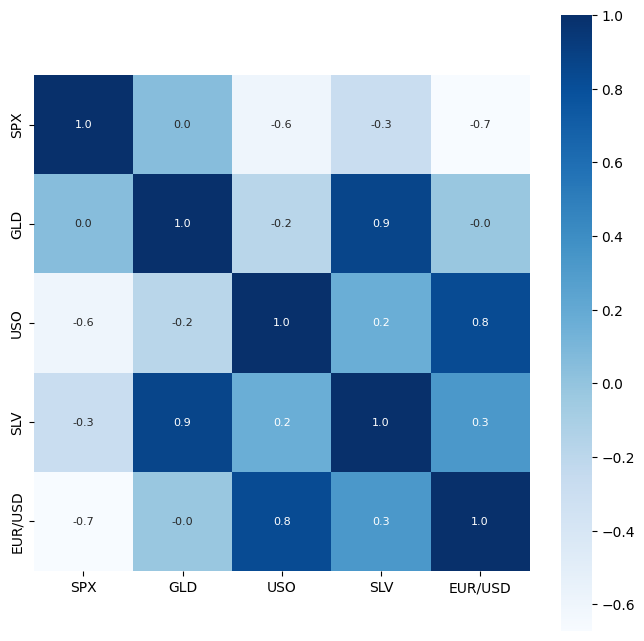

In [112]:
# constructing a heatmap to understand the correlatiom
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [113]:
# correlation values of GLD
print(correlation['GLD'])

SPX        0.049345
GLD        1.000000
USO       -0.186360
SLV        0.866632
EUR/USD   -0.024375
Name: GLD, dtype: float64


<ipython-input-51-b94eac2e88dd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gold_data['GLD'],color='green')


<Axes: xlabel='GLD', ylabel='Density'>

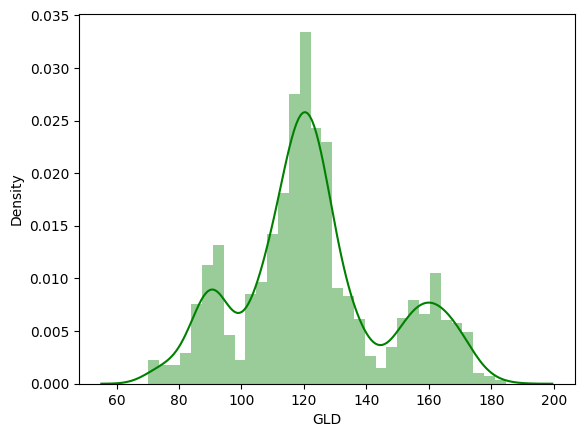

In [51]:
# checking the distribution of the GLD Price
sns.distplot(gold_data['GLD'],color='green')

Splitting the Features and Target

In [52]:
X = gold_data.drop(['Date','GLD'],axis=1)
Y = gold_data['GLD']

In [53]:
print(X)

              SPX        USO      SLV   EUR/USD
0     1447.160034  78.470001  15.1800  1.471692
1     1447.160034  78.370003  15.2850  1.474491
2     1411.630005  77.309998  15.1670  1.475492
3     1416.180054  75.500000  15.0530  1.468299
4     1390.189941  76.059998  15.5900  1.557099
...           ...        ...      ...       ...
2285  2671.919922  14.060000  15.5100  1.186789
2286  2697.790039  14.370000  15.5300  1.184722
2287  2723.070068  14.410000  15.7400  1.191753
2288  2730.129883  14.380000  15.5600  1.193118
2289  2725.780029  14.405800  15.4542  1.182033

[2290 rows x 4 columns]


In [54]:
print(Y)

0        84.860001
1        85.570000
2        85.129997
3        84.769997
4        86.779999
           ...    
2285    124.589996
2286    124.330002
2287    125.180000
2288    124.489998
2289    122.543800
Name: GLD, Length: 2290, dtype: float64


Splitting into Training data and Test Data

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

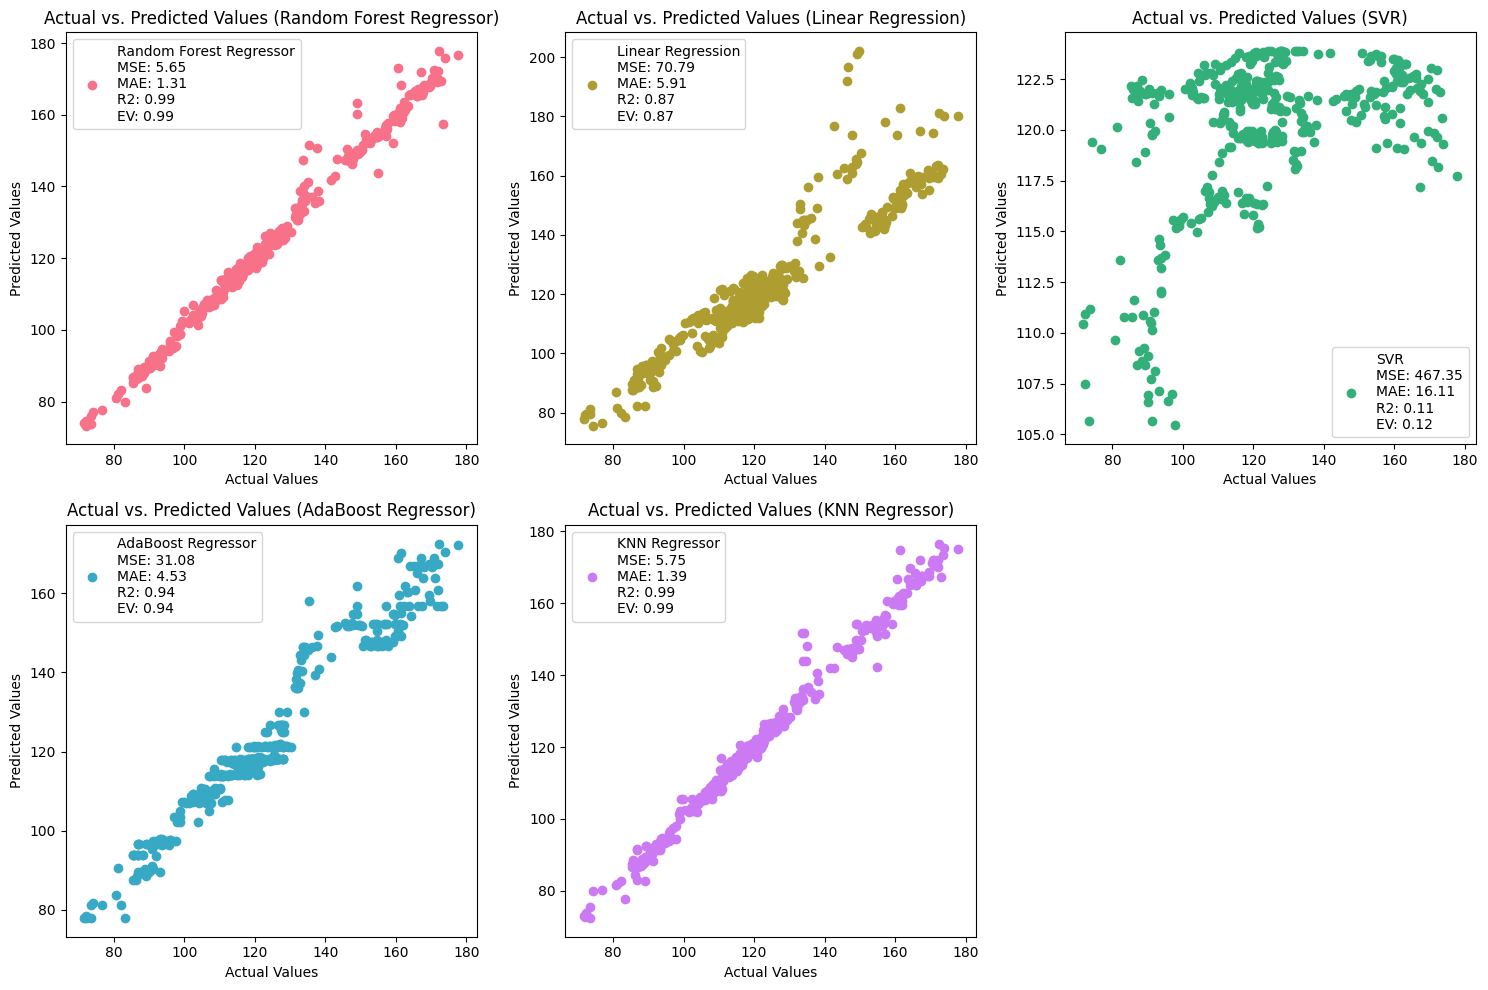

The best model is: Random Forest Regressor
Best Model Mean Squared Error: 5.64597070280318
Best Model R-squared: 0.9892955914788849


In [96]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set a color palette with distinct colors
colors = sns.color_palette("husl", len(models))

# Train Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)
linear_pred = linear_regressor.predict(X_test)

# Train Support Vector Regression (SVR) model
svr_regressor = SVR()
svr_regressor.fit(X_train, Y_train)
svr_pred = svr_regressor.predict(X_test)

# Train AdaBoost model
adaboost_regressor = AdaBoostRegressor()
adaboost_regressor.fit(X_train, Y_train)
adaboost_pred = adaboost_regressor.predict(X_test)

# Train k-Nearest Neighbors (KNN) model
knn_regressor = make_pipeline(StandardScaler(), KNeighborsRegressor())
knn_regressor.fit(X_train, Y_train)
knn_pred = knn_regressor.predict(X_test)

# Define a list of metrics
metrics_list = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared', 'Explained Variance']

models = {
    'Random Forest Regressor': regressor,
    'Linear Regression': linear_regressor,
    'SVR': svr_regressor,
    'AdaBoost Regressor': adaboost_regressor,
    'KNN Regressor': knn_regressor
}

best_model_name = None
best_model_mse = float('inf')  # Initialize with a large value
best_model_r2 = -float('inf')  # Initialize with a small value

plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items(), start=1):
    plt.subplot(2, 3, i)

    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    ev = explained_variance_score(Y_test, predictions)

    plt.plot(Y_test, predictions, label=f'{name}\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}\nEV: {ev:.2f}', linestyle='None', marker='o', color=colors[i-1])
    plt.title(f'Actual vs. Predicted Values ({name})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    # Update the best model if the current model performs better
    if mse < best_model_mse and r2 > best_model_r2:
        best_model_name = name
        best_model_mse = mse
        best_model_r2 = r2

plt.tight_layout()
plt.show()

# Print the best model
print(f"The best model is: {best_model_name}")
print(f"Best Model Mean Squared Error: {best_model_mse}")
print(f"Best Model R-squared: {best_model_r2}")


Model Training:
Random Forest Regressor

In [98]:
regressor = RandomForestRegressor(n_estimators=100)

In [100]:
# training the model
regressor.fit(X_train,Y_train)

RandomForestRegressor()

Model Evaluation

In [101]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [59]:
print(test_data_prediction)

[168.42069921  82.05589972 116.11950031 127.71640083 120.68360156
 154.49699751 150.20119914 126.13079979 117.39199881 126.03170063
 116.59320107 172.06440061 141.76919795 167.78519933 115.1746998
 117.70280069 138.84870284 170.14760065 159.60670267 157.31550002
 155.1321     125.18280008 176.59449929 157.05420277 125.2312006
  93.69889984  77.64680021 120.42269994 119.14849951 167.44600006
  88.13130032 125.3751999   91.1255007  117.6589004  121.12909885
 136.14860082 115.70560128 115.11900091 147.31109983 107.14670067
 104.63210256  87.14179765 126.58170051 117.94160044 151.99879929
 119.5368001  108.49399985 107.95089792  93.16170061 126.81849846
  74.7151005  113.57079905 121.28170024 111.13859916 118.85099902
 120.81329915 159.15089976 168.204301   147.19569717  86.04129859
  94.28580061  86.76229881  90.56730042 118.98470078 126.4823002
 127.62009994 169.20939981 122.20259901 117.63159905  98.24820027
 168.11420167 143.01969884 132.09020212 121.16990243 121.15979959
 119.6586007 

In [102]:
# R squared error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9900148014695936


Compare the Actual Values and Predicted Values in a Plot

In [103]:
Y_test = list(Y_test)

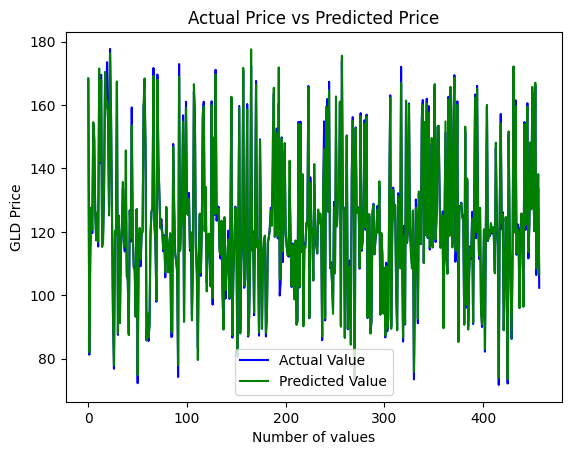

In [105]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

The best month to buy gold is January (1)


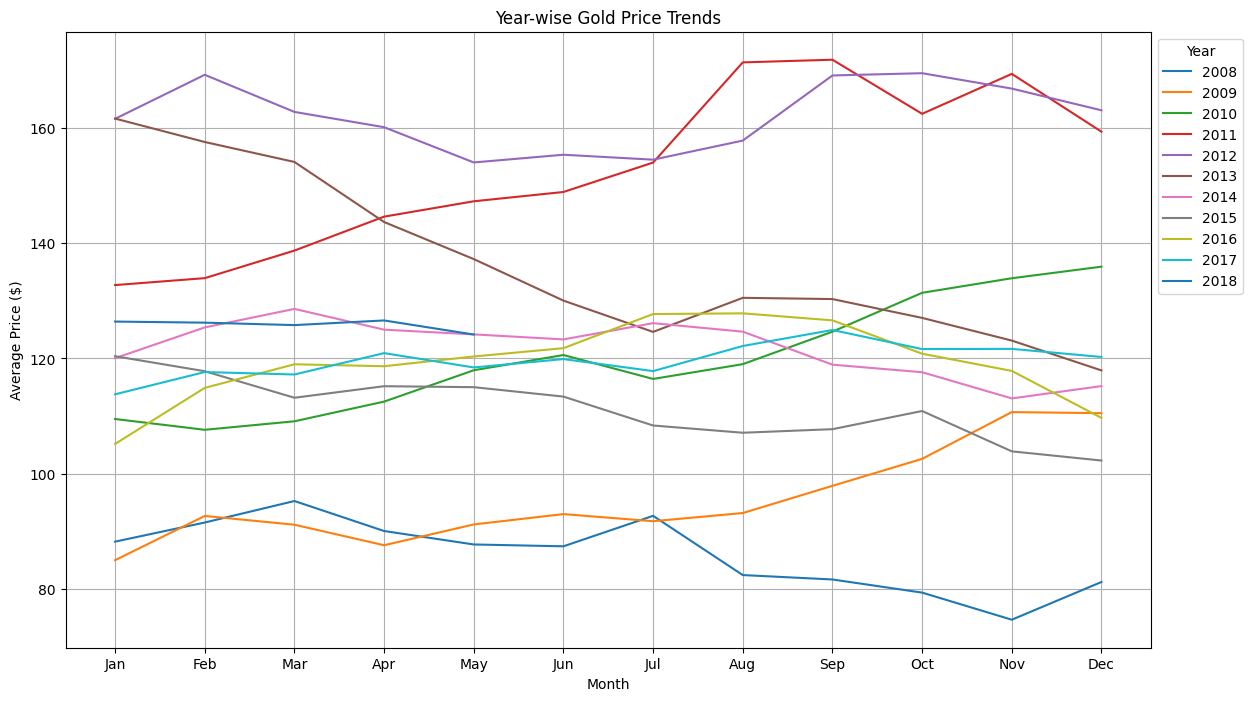

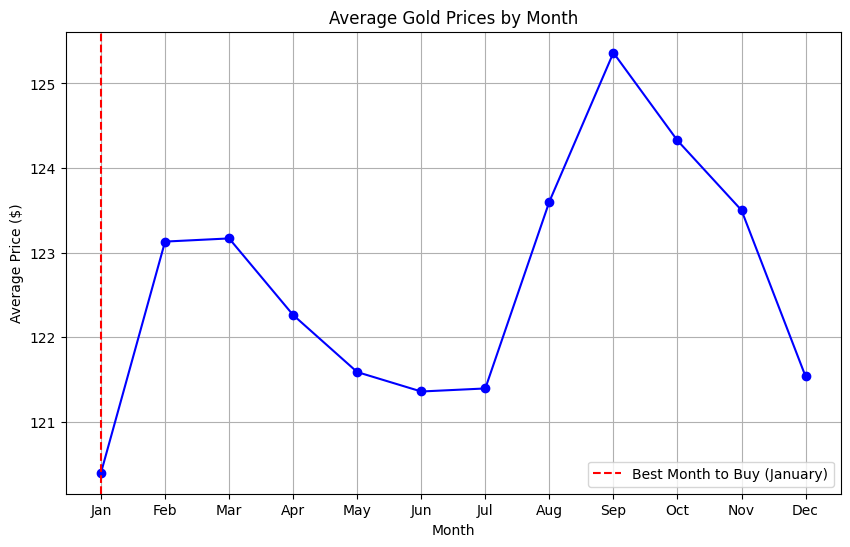

In [66]:
# Load the dataset
df = pd.read_csv('gld_price_data.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Adjust the date format

# Extract year and month from the 'Date' column
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# Calculate the average price for each month
average_prices_by_month = df.groupby(['year', 'month'])['GLD'].mean().unstack()

# Identify the month with the lowest average price (considered as the best time to buy)
best_month_to_buy = average_prices_by_month.mean(axis=0).idxmin()
best_month_name = df[df['month'] == best_month_to_buy]['Date'].dt.strftime('%B').iloc[0]

print(f'The best month to buy gold is {best_month_name} ({best_month_to_buy})')

# Plotting the average gold prices by month
plt.figure(figsize=(14, 8))

# Plot year-wise trends
for year in average_prices_by_month.index:
    plt.plot(average_prices_by_month.columns, average_prices_by_month.loc[year], label=year)

plt.title('Year-wise Gold Price Trends')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.xticks(range(1, 13), [month[:3] for month in df['Date'].dt.strftime('%B').unique()])  # Display abbreviated month names
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Plotting the average gold prices by month and best month to buy
plt.figure(figsize=(10, 6))
plt.plot(average_prices_by_month.columns, average_prices_by_month.mean(), marker='o', linestyle='-', color='b')
plt.title('Average Gold Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.xticks(range(1, 13), [month[:3] for month in df['Date'].dt.strftime('%B').unique()])  # Display abbreviated month names
plt.grid(True)
plt.axvline(x=best_month_to_buy, color='r', linestyle='--', label=f'Best Month to Buy ({best_month_name})')
plt.legend()
plt.show()
